In [2]:
import pandas as pd
import numpy as np
import tensorflow
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Загрузка данных
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

Train samples: 31755, Test samples: 7939


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocess_text(text):
    # Стоп-слова
    stop_words = stopwords.words('english')
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    text = re.sub(r'\d+', '', text)      # Удаление чисел
    text = ' '.join([word for word in text.split() if word not in stop_words and len(word) > 2])
    return text

train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Параметры
max_words = 20000  # Увеличенный размер словаря
max_len = 30      # Увеличенная длина последовательности
embedding_dim = 300 # Большая размерность эмбеддингов

# Токенизация
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['cleaned_text']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['cleaned_text']), maxlen=max_len)

# Кодирование меток
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['target'])
num_classes = len(label_encoder.classes_)

In [5]:
# Пример для GloVe (файл 'glove.6B.300d.txt' должен быть в директории)
def load_glove_embeddings():
    embeddings_index = {}
    with open('data/glove.6B.300d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings()

# Создание матрицы эмбеддингов
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words and word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=False  # Закрепляем предобученные эмбеддинги
    ),
    Bidirectional(LSTM(512, return_sequences=True)), #258
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(512)), #128
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 1024)         3330048   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 1024)          0         
                                                                 
 batch_normalization (BatchN  (None, 30, 1024)         4096      
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             6295552   
 nal)                                                            
                                                        

In [7]:
from sklearn.metrics import f1_score

class F1Metrics(tensorflow.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_pred, average='macro')
        print(f"Val F1-Score: {f1:.4f}")
        logs['val_f1'] = f1

# Разделение данных
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y, test_size=0.2, random_state=42, stratify=y
)

# Обучение
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_f1', patience=3, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2),
        F1Metrics(X_val, y_val)
    ]
)

Epoch 1/30
199/199 [==============================] - 2s 7ms/step
Val F1-Score: 0.2439
397/397 [==============================] - 17s 31ms/step - loss: 1.8127 - accuracy: 0.5393 - val_loss: 1.6298 - val_accuracy: 0.5700 - lr: 0.0010 - val_f1: 0.2439
Epoch 2/30
199/199 [==============================] - 1s 7ms/step
Val F1-Score: 0.3554
397/397 [==============================] - 12s 31ms/step - loss: 1.5308 - accuracy: 0.5916 - val_loss: 1.5225 - val_accuracy: 0.6100 - lr: 0.0010 - val_f1: 0.3554
Epoch 3/30
199/199 [==============================] - 1s 6ms/step
Val F1-Score: 0.3882
397/397 [==============================] - 12s 30ms/step - loss: 1.4082 - accuracy: 0.6121 - val_loss: 1.5016 - val_accuracy: 0.6122 - lr: 0.0010 - val_f1: 0.3882
Epoch 4/30
199/199 [==============================] - 1s 7ms/step
Val F1-Score: 0.3934
397/397 [==============================] - 11s 28ms/step - loss: 1.3023 - accuracy: 0.6325 - val_loss: 1.4943 - val_accuracy: 0.6090 - lr: 0.0010 - val_f1: 0.3934


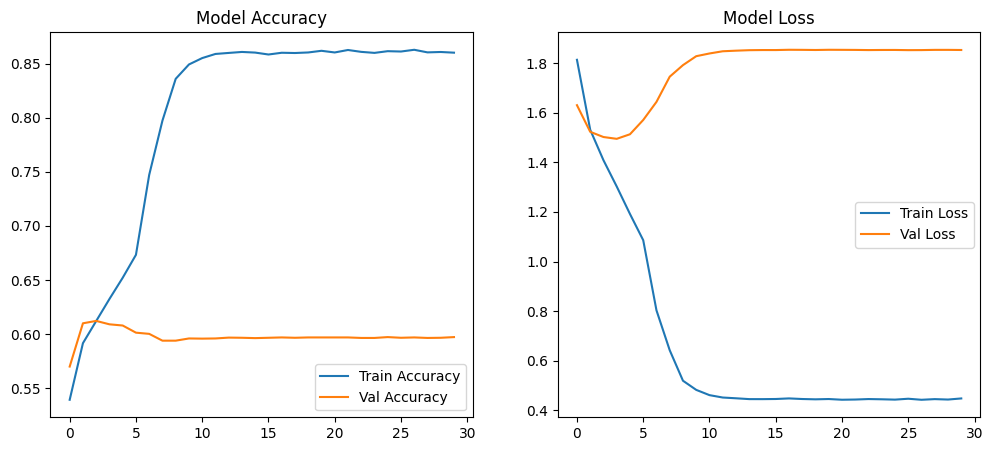

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# # Отчет классификации
# from sklearn.metrics import classification_report
# y_pred = np.argmax(model.predict(X_val), axis=1)
# print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

In [9]:
test_pred = np.argmax(model.predict(X_test), axis=1)
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': label_encoder.inverse_transform(test_pred)
})
submission.to_csv('submissions/submission_rnn_large_emb_5.csv', index=False)

249/249 [==============================] - 2s 6ms/step
